<a href="https://colab.research.google.com/github/cram05/practicas-machine-learning/blob/main/M%C3%A9todos_Basados_en_%C3%81rboles_(Solucionado20211209).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos basados en árboles

In [ ]:
# Importar librerias

# Librerias para cargar el conjunto de datos
from google.colab import files
import io

# Librerias para la implementación
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Librerias para procesamiento
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

## Árboles de Decisión

### Regresión

#### Algoritmo de implementación

In [ ]:
class arbol_reg:

  # Entrenamiento
  def entrenar(self, X, y, t_min = 5):

    # Identificadores de observaciones (filas)
    id_obs = np.array(np.arange(len(y)))

    self.a_reg = nodo_reg(X, y, id_obs, t_min)
    return self

  # Predicción
  def predecir(self, X):
    return self.a_reg.predecir(X)

In [ ]:
class nodo_reg:

    # Instanciar nodo
    def __init__(self, X, y, id_obs, t_min = 5):

        # Datos
        self.X = X
        self.y = y
        self.id_obs = id_obs

        # Tamaño de nodo mínimo
        self.t_min = t_min

        # Número variables y observaciones
        self.n_vars = X.shape[1]
        self.n_obs = len(id_obs)

        # Estimación de respuesta del nodo
        self.y_estim = np.mean(y[id_obs])

        # Error/Impureza
        self.impureza_inicial = sum((self.y-self.y_estim)**2)
        self.impureza = sum((self.y-self.y_estim)**2)

        # Buscar variable separadora al instanciar
        self.buscar_var_sep()


    # Buscar variable separadora
    def buscar_var_sep(self):

        # Buscar punto de separación por variable
        for var_id in range(self.n_vars):
          self.buscar_mejor_sep(var_id)

        # Si el nodo es una hoja no hacer cambios
        if self.es_hoja:
          return

        # Definir variable separadora
        x = self.var_sep

        # Particionar nodo e instanciar nodos hijos
        lhs = np.nonzero(x <= self.valor_sep)[0]
        rhs = np.nonzero(x > self.valor_sep)[0]

        self.lhs = nodo_reg(self.X, self.y, self.id_obs[lhs], self.t_min)
        self.rhs = nodo_reg(self.X, self.y, self.id_obs[rhs], self.t_min)

    # Buscar una mejor separación dada una variable
    def buscar_mejor_sep(self, var_id):

        # Valores candidatos
        x = self.X[self.id_obs, var_id]

        # Evaluar valores candidatos
        for i in range(self.n_obs):
          # Posible partición
          lhs = (x <= x[i])
          rhs = (x > x[i])

          # Verificar que las particiones tienen almenos el tamaño mínimo
          if rhs.sum() < self.t_min or lhs.sum() < self.t_min:
            continue

          # Calcular score
          nueva_impureza = self.calcular_impureza(lhs, rhs)

          # Si la impureza es menor a la actual, actualizar atributos
          if nueva_impureza < self.impureza:
            self.var_id = var_id
            self.impureza = nueva_impureza
            self.valor_sep = x[i]

    # Calcular impureza
    def calcular_impureza(self, lhs, rhs):

        y = self.y[self.id_obs]

        lhs_std = sum((y[lhs]-np.mean(y[lhs]))**2)
        rhs_std = sum((y[rhs]-np.mean(y[rhs]))**2)

        return lhs_std + rhs_std

    # Definir variable separadora
    @property
    def var_sep(self):
      return self.X[self.id_obs,self.var_id]

    # Definir si el nodo es un nodo hoja o no
    @property
    def es_hoja(self):
      return (self.impureza == self.impureza_inicial)

    # Predecir respuestas
    def predecir(self, x):
        return np.array([self.predecir_obs(xi) for xi in x])

    # Predicción de respuesta por observación
    def predecir_obs(self, xi):

        if self.es_hoja:
          return self.y_estim

        if xi[self.var_id] <= self.valor_sep:
          node = self.lhs
        else:
          node = self.rhs

        return node.predecir_obs(xi)

#### Ejemplo numérico

A continuación resolveremos nuevamente el problema de estimar el volumen de un árbol.

In [ ]:
# Carguemos los datos
uploaded = files.upload()

Saving trees.csv to trees (6).csv


In [ ]:
# Lectura
trees = pd.read_csv('trees.csv',index_col=0)
trees.head(10)

,C,A,V
1,8.3,70,10.3
2,8.6,65,10.3
3,8.8,63,10.2
4,10.5,72,16.4
5,10.7,81,18.8
6,10.8,83,NaN
7,11.0,66,15.6
8,11.0,75,18.2
9,11.1,80,22.6
10,11.2,75,19.9


In [ ]:
# Definamos el conjunto de entrenamiento...
X = trees[trees.V.notna()].loc[:,['C','A']]
y = trees[trees.V.notna()].loc[:,['V']]

##### Usando nuestro árbol

In [ ]:
# Entrenar
my_reg_tree = arbol_reg().entrenar(X.values, y.values)


In [ ]:
# Predicción (Datos del árbol 6)
my_reg_tree.predecir([[10.8,83]]).round(2)

array([14.26])

Al parecer hicimos un buen trabajo. Sin embargo una forma de validar esto es imaginar que todos los datos de entrenamiento tienen volúmenes desconocidos. Luego, podemos estimar volúmenes y calcular una métrica de error.

In [ ]:
# Calcular estimaciones para todos los árboles
my_trees_new = pd.DataFrame(pd.concat([X,y],axis=1))
my_trees_new["V_hat"] = my_reg_tree.predecir(X.values).round(2)
my_trees_new.head(10)

,C,A,V,V_hat
1,8.3,70,10.3,14.26
2,8.6,65,10.3,14.26
3,8.8,63,10.2,14.26
4,10.5,72,16.4,14.26
5,10.7,81,18.8,14.26
7,11.0,66,15.6,14.26
8,11.0,75,18.2,14.26
9,11.1,80,22.6,21.36
10,11.2,75,19.9,21.36
11,11.3,79,24.2,21.36


In [ ]:
# Calculemos errores al cuadrado
my_trees_new["e2"] = (my_trees_new.V - my_trees_new.V_hat)**2
my_trees_new.head(5)

,C,A,V,V_hat,e2
1,8.3,70,10.3,14.26,15.6816
2,8.6,65,10.3,14.26,15.6816
3,8.8,63,10.2,14.26,16.4836
4,10.5,72,16.4,14.26,4.5796
5,10.7,81,18.8,14.26,20.6116


In [ ]:
# Obetengamos el error cuadrático medio
my_trees_new.e2.sum()/my_trees_new.shape[0]

34.484959999999994

##### Usando sklearn

In [ ]:
# Importemos la librería de sklearn
from sklearn import tree

# Definición del modelo de árbol
sk_reg_tree = tree.DecisionTreeRegressor(min_samples_leaf=5)

In [ ]:
# Entrenamiento
sk_reg_tree = sk_reg_tree.fit(X, y)

In [ ]:
# Predicción (Datos del árbol 6)
sk_reg_tree.predict([[10.8,83]]).round(2)

array([14.26])

In [ ]:
# Calcular estimaciones para todos los árboles
sk_trees_new = pd.DataFrame(pd.concat([X,y],axis=1))
sk_trees_new["V_hat"]=sk_reg_tree.predict(X).round(2)
sk_trees_new.head(10)

,C,A,V,V_hat
1,8.3,70,10.3,14.26
2,8.6,65,10.3,14.26
3,8.8,63,10.2,14.26
4,10.5,72,16.4,14.26
5,10.7,81,18.8,14.26
7,11.0,66,15.6,14.26
8,11.0,75,18.2,14.26
9,11.1,80,22.6,21.36
10,11.2,75,19.9,21.36
11,11.3,79,24.2,21.36


In [ ]:
# Calculemos errores al cuadrado
sk_trees_new["e2"] = (sk_trees_new.V - sk_trees_new.V_hat)**2
sk_trees_new.head(5)


,C,A,V,V_hat,e2
1,8.3,70,10.3,14.26,15.6816
2,8.6,65,10.3,14.26,15.6816
3,8.8,63,10.2,14.26,16.4836
4,10.5,72,16.4,14.26,4.5796
5,10.7,81,18.8,14.26,20.6116


In [ ]:
# Obetengamos el error cuadrático medio
sk_trees_new.e2.sum()/sk_trees_new.shape[0]

34.484959999999994

Ahora grafiquemos nuestro árbol. ¿Qué tan complejo será?

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


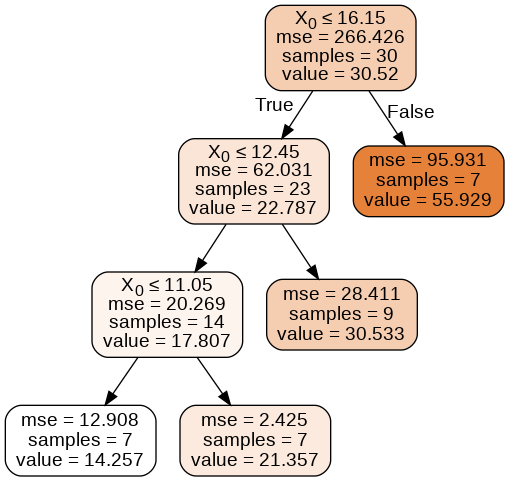

In [ ]:
# Importar librerias
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Definir archivo
dot_data = StringIO()

# Exportar datos del árbol al archivo
export_graphviz(sk_reg_tree,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True)

# Definir grafo con datos del árbol
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Mostrar gráfico
Image(graph.create_png())

### Clasificación

#### Algoritmo de implementación

In [ ]:
class arbol_clasif:

  # Entrenamiento
  def entrenar(self, X, y, t_min = 5, m_imp ="igini"):

    # Identificadores de observaciones (filas)
    id_obs = np.array(np.arange(len(y)))

    self.a_clasif = nodo_clasif(X, y, id_obs, t_min, m_imp)
    return self

  # Predicción
  def predecir(self, X):
    return self.a_clasif.predecir(X)

In [ ]:
def calcular_igini(y):
  categorias = np.unique(y)
  igini = 0
  n_obs = len(y)

  for c in categorias:
    p_c = np.sum(y == c)/n_obs
    igini = igini + p_c*(1-p_c)

  return igini

In [ ]:
def calcular_enropia(y):
  pass

In [ ]:
class nodo_clasif:

    # Instanciar nodo
    def __init__(self, X, y, id_obs, t_min, m_imp):

        # Datos
        self.X = X
        self.y = y
        self.id_obs = id_obs
        self.m_imp = m_imp

        # Tamaño de nodo mínimo
        self.t_min = t_min

        # Número variables y observaciones
        self.n_vars = X.shape[1]
        self.n_obs = len(id_obs)

        # Estimación de respuesta del nodo
        self.y_estim = int(stats.mode(y[id_obs])[0])

        # Error/Impureza
        if self.m_imp == "igini":

          self.impureza_inicial = calcular_igini(y)
          self.impureza = calcular_igini(y)

        elif self.m_imp == "entropia":

          self.impureza_inicial = calcular_entropia(y)
          self.impureza = calcular_entropia(y)

        else:

          return "Error, medida de impureza no reconocida"

        # Buscar variable separadora al instanciar
        self.buscar_var_sep()


    # Buscar variable separadora
    def buscar_var_sep(self):

        # Buscar punto de separación por variable
        for var_id in range(self.n_vars):
          self.buscar_mejor_sep(var_id)

        # Si el nodo es una hoja no hacer cambios
        if self.es_hoja:
          return

        # Definir variable separadora
        x = self.var_sep

        # Particionar nodo e instanciar nodos hijos
        lhs = np.nonzero(x <= self.valor_sep)[0]
        rhs = np.nonzero(x > self.valor_sep)[0]

        self.lhs = nodo_clasif(self.X, self.y, self.id_obs[lhs], self.t_min, self.m_imp)
        self.rhs = nodo_clasif(self.X, self.y, self.id_obs[rhs], self.t_min, self.m_imp)

    # Buscar una mejor separación dada una variable
    def buscar_mejor_sep(self, var_id):

        # Valores candidatos
        x = self.X[self.id_obs, var_id]

        # Evaluar valores candidatos
        for i in range(self.n_obs):

            # Posible partición
            lhs = (x <= x[i])
            rhs = (x > x[i])

            # Verificar que las particiones tienen almenos el tamaño mínimo
            if rhs.sum() < self.t_min or lhs.sum() < self.t_min:
              continue

            # Calcular score
            nueva_impureza = self.calcular_impureza(lhs, rhs)

            # Si la impureza es menor a la actual, actualizar atributos
            if nueva_impureza < self.impureza:
                self.var_id = var_id
                self.impureza = nueva_impureza
                self.valor_sep = x[i]

    # Calcular impureza
    def calcular_impureza(self, lhs, rhs):

        y = self.y[self.id_obs]

        if self.m_imp == "igini":

          lhs_imp = calcular_igini(y[lhs])
          rhs_imp = calcular_igini(y[rhs])

        elif self.m_imp == "entropia":

          lhs_imp = calcular_entropia(y[lhs])
          rhs_imp = calcular_entropia(y[rhs])

        else:

          return "Error, medida de impureza no reconocida"

        return lhs_imp + rhs_imp

    # Definir varaible separadora
    @property
    def var_sep(self):
      return self.X[self.id_obs,self.var_id]

    # Definir si el nodo es un nodo hoja o no
    @property
    def es_hoja(self):
      return (self.impureza == self.impureza_inicial)

    # Predecir respuestas
    def predecir(self, x):
        return np.array([self.predecir_obs(xi) for xi in x])

    # Predicción de respuesta por observación
    def predecir_obs(self, xi):

        if self.es_hoja:
          return self.y_estim

        if xi[self.var_id] <= self.valor_sep:
          node = self.lhs
        else:
          node = self.rhs

        return node.predecir_obs(xi)

#### Ejemplo numérico

Ahora consideremos el conjunto de datos sobre tiroides.

In [ ]:
uploaded = files.upload()

Saving newthyroid.csv to newthyroid (6).csv


In [ ]:
thyroids = pd.read_csv('newthyroid.csv')
thyroids.head()

,T3resin,Thyroxin,Triiodothyronine,Thyroidstimulating,TSH_value,Class
0,107,10.1,2.2,0.9,2.7,1
1,113,9.9,3.1,2.0,5.9,1
2,127,12.9,2.4,1.4,0.6,1
3,109,5.3,1.6,1.4,1.5,1
4,105,7.3,1.5,1.5,-0.1,1


In [ ]:
thyroids.columns = ['T3','TRX','TRI','TRS','TSH','Tipo']
thyroids_selected = thyroids.loc[:,['T3','TRX','Tipo']]
thyroids_selected.head()

,T3,TRX,Tipo
0,107,10.1,1
1,113,9.9,1
2,127,12.9,1
3,109,5.3,1
4,105,7.3,1


Recordemos los datos del nuevo sujeto

In [ ]:
# Nuevo sujeto
new_subject = [136,12,np.nan]
new_subject

[136, 12, nan]

In [ ]:
# Primero debemos definir el conjunto de entrenamiento...
X = thyroids_selected.loc[:,['T3','TRX']]
y = thyroids_selected.loc[:,['Tipo']]

##### Usando nuestro árbol

In [ ]:
# Entrenar
my_clas_tree = arbol_clasif().entrenar(X.values, y.values)

In [ ]:
# Predicción (Datos del nuevo sujeto)
my_clas_tree.predecir([[new_subject[0], new_subject[1]]])

array([1])

In [ ]:
# Predicciones para todos los sujetos
my_clas_tree.predecir(X.values)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1])

In [ ]:
# Matriz de confusión
my_mc = pd.crosstab(my_clas_tree.predecir(X.values),
                    np.ravel(y))
my_mc

col_0,1,2,3
row_0,,,
1,147,2,2
2,1,33,0
3,2,0,28


In [ ]:
# Tasa de clasificación erronea
(1-np.diag(my_mc).sum()/len(y))*100

3.2558139534883734

##### Usando sklearn

In [ ]:
# Importemos la librería de sklearn
from sklearn import tree

In [ ]:
# Definición del árbol de clasificación
sk_clas_tree = tree.DecisionTreeClassifier(min_samples_leaf=5)

#entrenamiento del árbol
sk_clas_tree = sk_clas_tree.fit(X, y)

In [ ]:
# Predicción (Datos del nuevo sujeto)
sk_clas_tree.predict([[new_subject[0], new_subject[1]]])

array([1])

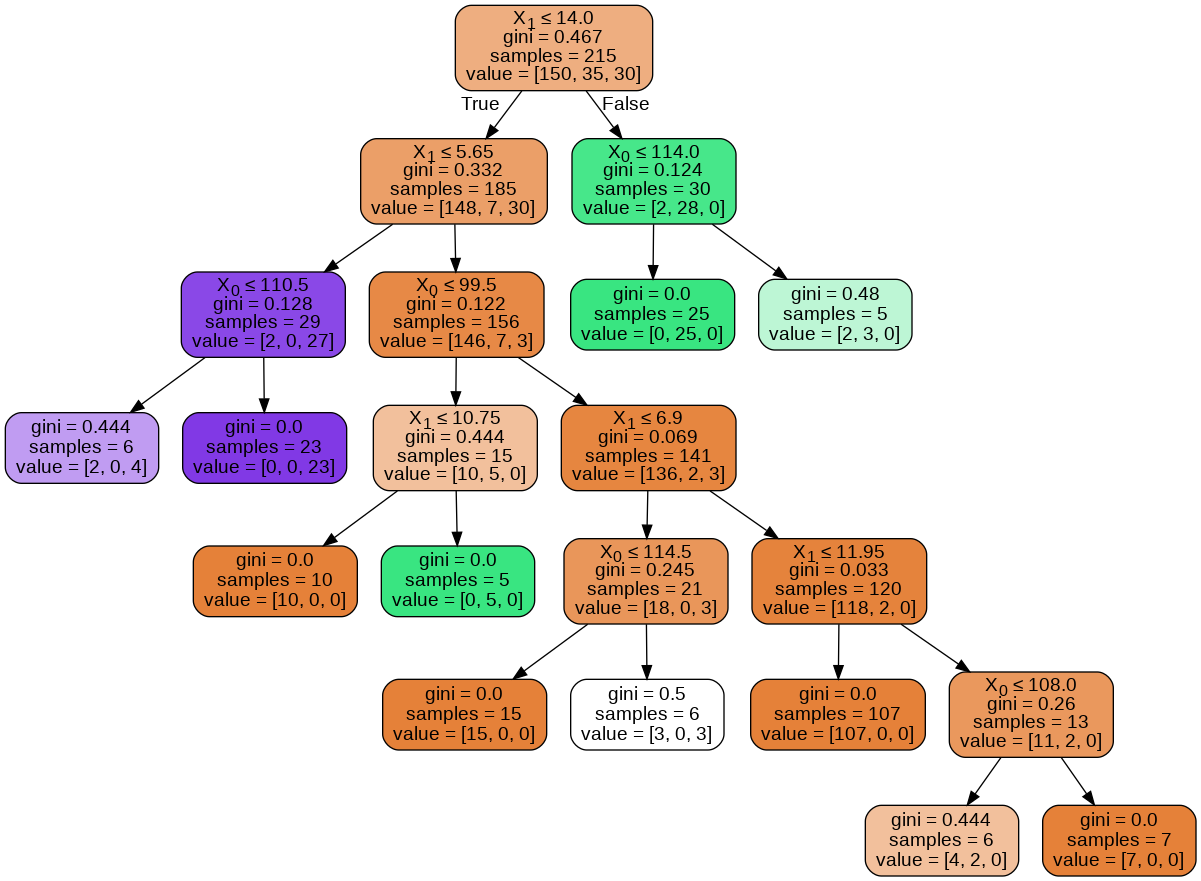

In [ ]:
# Importar librerias
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Definir archivo
dot_data = StringIO()

# Exportar datos del árbol al archivo
export_graphviz(sk_clas_tree,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True)

# Definir grafo con datos del árbol
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Mostrar gráfico
Image(graph.create_png())

In [ ]:
# Matriz de confusión
sk_mc = pd.crosstab(sk_clas_tree.predict(X),np.ravel(y))
sk_mc

col_0,1,2,3
row_0,,,
1,146,2,3
2,2,33,0
3,2,0,27


In [ ]:
# Tasa de clasificación erronea
(1-np.diag(sk_mc).sum()/len(y))*100

4.1860465116279055

## Bosques Aleatorios | Random Forest

### Regresión

#### Algoritmo de implementación

In [ ]:
class bosque_aleatorio_reg:

  # Instanciar objeto
  def __init__(self, B, m, t_min =5):
    self.B = B
    self.m = m
    self.t_min = t_min

  # Entrenamiento
  def entrenar(self, X, y):

    # Inicializar bosque
    self.bosque = []

    # Definir ids para observaciones y variables
    id_obs = np.array(np.arange(len(y)))
    id_vars = np.array(np.arange(X.shape[1]))

    for b in range(self.B):

      # Extraer muestra bootstrap
      id_obs_sample =  resample(id_obs, replace = True)
      X_sample = X[id_obs_sample]
      y_sample = y[id_obs_sample]

      # Extraer muestra aleatoria de variables
      id_vars_sample = np.sort(resample(id_vars, n_samples = self.m, replace = False))
      X_sample = X_sample[:,id_vars_sample]

      # Entrenar árboles
      self.bosque.append(arbol_reg())
      self.bosque[b].entrenar(X_sample, y_sample, self.t_min)


  # Obtener predicciones
  def predecir(self, X):

    predicciones_bosque = []

    for arbol in self.bosque:
      predicciones_bosque.append(arbol.predecir(X))

    return np.mean(predicciones_bosque,axis=0)



#### Ejemplo numérico

In [ ]:
uploaded = files.upload()

Saving trees.csv to trees (7).csv


In [ ]:
# Lectura
trees = pd.read_csv('trees.csv',index_col=0)
trees.head(10)

,C,A,V
1,8.3,70,10.3
2,8.6,65,10.3
3,8.8,63,10.2
4,10.5,72,16.4
5,10.7,81,18.8
6,10.8,83,NaN
7,11.0,66,15.6
8,11.0,75,18.2
9,11.1,80,22.6
10,11.2,75,19.9


In [ ]:
# Definamos el conjunto de entrenamiento...
X = trees[trees.V.notna()].loc[:,['C','A']]
y = trees[trees.V.notna()].loc[:,['V']]

##### Usando nuestro bosque

In [ ]:
# Definición del modelo
my_rf_reg =  bosque_aleatorio_reg(B=100, m=2)

In [ ]:
# Entrenamiento
my_rf_reg.entrenar(X.values,y.values)

In [ ]:
# Predicción (Datos del árbol 6)
my_rf_reg.predecir([[10.8,83]]).round(2)

array([17.41])

In [ ]:
# Calcular estimaciones para todos los árboles
my_trees_new = pd.DataFrame(pd.concat([X,y],axis=1))
my_trees_new["V_hat"] = my_rf_reg.predecir(X.values).round(2)
my_trees_new.head(10)

,C,A,V,V_hat
1,8.3,70,10.3,14.36
2,8.6,65,10.3,14.16
3,8.8,63,10.2,14.23
4,10.5,72,16.4,15.31
5,10.7,81,18.8,16.67
7,11.0,66,15.6,16.21
8,11.0,75,18.2,16.80
9,11.1,80,22.6,21.68
10,11.2,75,19.9,21.03
11,11.3,79,24.2,21.88


In [ ]:
# Calculemos errores al cuadrado
my_trees_new["e2"] = (my_trees_new.V - my_trees_new.V_hat)**2
my_trees_new.head(5)

,C,A,V,V_hat,e2
1,8.3,70,10.3,14.36,16.4836
2,8.6,65,10.3,14.16,14.8996
3,8.8,63,10.2,14.23,16.2409
4,10.5,72,16.4,15.31,1.1881
5,10.7,81,18.8,16.67,4.5369


In [ ]:
# Obetengamos el error cuadrático medio
my_trees_new.e2.sum()/my_trees_new.shape[0]

28.198693333333328

##### Usando sklearn

In [ ]:
# Importemos la librería de sklearn
from sklearn.ensemble import RandomForestRegressor

# Definición del modelo
sk_reg_rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features = 2)

In [ ]:
# Entrenamiento
sk_reg_rf.fit(X, y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [ ]:
# Predicción (Datos del árbol 6)
sk_reg_rf.predict([[10.8,83]]).round(2)

array([15.96])

In [ ]:
# Calcular estimaciones para todos los árboles
sk_trees_new = pd.DataFrame(pd.concat([X,y],axis=1))
sk_trees_new["V_hat"] = sk_reg_rf.predict(X.values).round(2)
sk_trees_new.head(10)

,C,A,V,V_hat
1,8.3,70,10.3,15.88
2,8.6,65,10.3,15.88
3,8.8,63,10.2,15.88
4,10.5,72,16.4,15.88
5,10.7,81,18.8,15.96
7,11.0,66,15.6,16.21
8,11.0,75,18.2,16.30
9,11.1,80,22.6,19.18
10,11.2,75,19.9,20.12
11,11.3,79,24.2,21.51


In [ ]:
# Calculemos errores al cuadrado
sk_trees_new["e2"] = (sk_trees_new.V - sk_trees_new.V_hat)**2
sk_trees_new.head(5)

,C,A,V,V_hat,e2
1,8.3,70,10.3,15.88,31.1364
2,8.6,65,10.3,15.88,31.1364
3,8.8,63,10.2,15.88,32.2624
4,10.5,72,16.4,15.88,0.2704
5,10.7,81,18.8,15.96,8.0656


In [ ]:
# Obetengamos el error cuadrático medio
sk_trees_new.e2.sum()/sk_trees_new.shape[0]

36.51726

### Clasificación

#### Algoritmo de implementación

In [ ]:
class bosque_aleatorio_clas:

  # Instanciar objeto
  def __init__(self, B, m, t_min =5, m_imp="igini"):
    self.B = B
    self.m_imp = m_imp
    self.m = m
    self.t_min = t_min

  # Entrenamiento
  def entrenar(self, X, y):

    # Inicializar bosque
    self.bosque = []

    # Definir ids para observaciones y variables
    id_obs = np.array(np.arange(len(y)))
    id_vars = np.array(np.arange(X.shape[1]))

    for b in range(self.B):

      # Extraer muestra bootstrap
      id_obs_sample =  resample(id_obs, replace = True)
      X_sample = X[id_obs_sample]
      y_sample = y[id_obs_sample]

      # Extraer muestra aleatoria de variables
      id_vars_sample = np.sort(resample(id_vars, n_samples = self.m, replace = False))
      X_sample = X_sample[:,id_vars_sample]

      # Entrenar árboles
      self.bosque.append(arbol_clasif())
      self.bosque[b].entrenar(X_sample, y_sample, self.t_min, self.m_imp)


  # Obtener predicciones
  def predecir(self, X):

    predicciones_bosque = []

    for arbol in self.bosque:
      predicciones_bosque.append(arbol.predecir(X))

    return stats.mode(predicciones_bosque, axis=0)[0][0]

In [ ]:
# Carguemos los datos
uploaded = files.upload()

Saving newthyroid.csv to newthyroid (7).csv


In [ ]:
thyroids = pd.read_csv('newthyroid.csv')
thyroids.head()

,T3resin,Thyroxin,Triiodothyronine,Thyroidstimulating,TSH_value,Class
0,107,10.1,2.2,0.9,2.7,1
1,113,9.9,3.1,2.0,5.9,1
2,127,12.9,2.4,1.4,0.6,1
3,109,5.3,1.6,1.4,1.5,1
4,105,7.3,1.5,1.5,-0.1,1


In [ ]:
thyroids.columns = ['T3','TRX','TRI','TRS','TSH','Tipo']
thyroids_selected = thyroids.loc[:,['T3','TRX','Tipo']]
thyroids_selected.head()

,T3,TRX,Tipo
0,107,10.1,1
1,113,9.9,1
2,127,12.9,1
3,109,5.3,1
4,105,7.3,1


In [ ]:
# Nuevo sujeto
new_subject = [136,12,np.nan]
new_subject

[136, 12, nan]

In [ ]:
# Primero debemos definir el conjunto de entrenamiento...
X = thyroids_selected.loc[:,['T3','TRX']]
y = thyroids_selected.loc[:,['Tipo']]

#### Ejemplo numérico

##### Usando nuestro bosque

In [ ]:
# Definición del modelo
my_clas_rf =  bosque_aleatorio_clas(B=100, m=2)

In [ ]:
# Entrenamiento
my_clas_rf.entrenar(X.values,y.values)

In [ ]:
# Predicción (Datos del nuevo sujeto)
my_clas_rf.predecir([[new_subject[0], new_subject[1]]])

array([1])

In [ ]:
# Predicciones para todos los sujetos
my_clas_rf.predecir(X.values)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 1, 2, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1])

In [ ]:
# Matriz de confusión
my_mc = pd.crosstab(my_clas_rf.predecir(X.values),np.ravel(y))
my_mc

col_0,1,2,3
row_0,,,
1,149,6,6
2,0,29,0
3,1,0,24


In [ ]:
# Tasa de clasificación erronea
(1-np.diag(my_mc).sum()/len(y))*100

6.04651162790698

##### Usando sklearn

In [ ]:
# Importar
from sklearn.ensemble import RandomForestClassifier

# Definición del bosque aleatorio
clas_rf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf = 5,
                                 max_features = 2)

# Entrenamiento del bosque
clas_rf = clas_rf.fit(X, y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


In [ ]:
# Predicción (Datos del nuevo sujeto)
clas_rf.predict([[new_subject[0], new_subject[1]]])

array([1])

In [ ]:
# Matriz de confusión
sk_mc = pd.crosstab(clas_rf.predict(X),np.ravel(y))
sk_mc

col_0,1,2,3
row_0,,,
1,146,3,3
2,2,32,0
3,2,0,27


In [ ]:
# Tasa de clasificación erronea
(1-np.diag(sk_mc).sum()/len(y))*100

4.651162790697672

###*Selección de Variables

Notemos que en el anterior ejercicio elegimos a priori las variables "T3" y "TRX" sin un criterio basado en evidencias para predecir la varaible de respuesta "Tipo". ¿Qué tal si consideramos todas las variables predictoras disponibles para estimar nuestra respuesta y luego evaluamos su importancia como predictores en el modelo? ¡Empecemos!

In [ ]:
# Definamos el nuevo conjunto de entrenamiento...
X_all = thyroids.loc[:,['T3','TRX','TRI','TRS','TSH']]
y = thyroids.loc[:,['Tipo']]

In [ ]:
# Definición del bosque aleatorio
clas_rf_all = RandomForestClassifier(n_estimators=100,
                                     min_samples_leaf = 5,
                                     max_features = 2)

# Entrenemos un nuevo bosque
clas_rf_all = clas_rf_all.fit(X_all, y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
# Matriz de confusión
pd.crosstab(clas_rf_all.predict(X_all),np.ravel(y))

col_0,1,2,3
row_0,,,
1,150,2,1
2,0,33,0
3,0,0,29


In [ ]:
# Tasa de clasificación erronea
(1-np.diag(pd.crosstab(clas_rf_all.predict(X_all),np.ravel(y))).sum()/len(y))*100

1.3953488372092981

In [ ]:
# Crear un ranking de importancia de variables
importance = pd.DataFrame(np.column_stack(
    (X_all.columns, clas_rf_all.feature_importances_)))
importance.columns = ["colname","importance"]
importance = importance.sort_values(by="importance")
importance

,colname,importance
0,T3,0.0497377
2,TRI,0.161271
4,TSH,0.167243
3,TRS,0.190569
1,TRX,0.43118


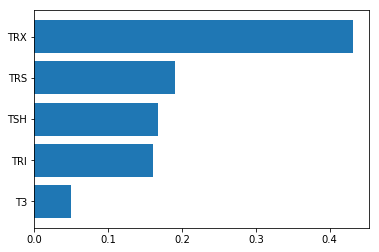

In [ ]:
# Graficar la importancia de las variables
plt.barh(importance.colname, importance.importance)
plt.show()

Veamos como se distribuyen los tipos de tiroides si consideramos las dos variables más importantes en su predicción (TRX y TRS).

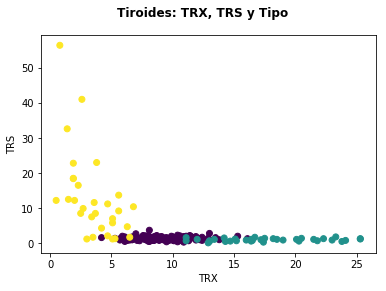

In [ ]:
# Sujetos de entrenamiento
plt.scatter(x = thyroids.TRX,
            y = thyroids.TRS,
            c = thyroids.Tipo,
            cmap='viridis')

plt.suptitle("Tiroides: TRX, TRS y Tipo", fontweight = 'bold')
plt.xlabel("TRX")
plt.ylabel("TRS")
plt.show()

Ahora veamos que tan buenos son los resultados si construimos un bosque aleatorio que considere las varaibles más importantes.

In [ ]:
# Definamos el nuevo conjunto de entrenamiento...
X_new = thyroids.loc[:,['TRX','TRS']]
y = thyroids.loc[:,['Tipo']]

In [ ]:
# Definición del bosque aleatorio
clas_rf_new = RandomForestClassifier(n_estimators=100,
                                     min_samples_leaf = 5,
                                     max_features = 2)

# Entrenemos un nuevo bosque
clas_rf_new = clas_rf_new.fit(X_new, y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
# Matriz de confusión
pd.crosstab(clas_rf_new.predict(X_new), np.ravel(y))

col_0,1,2,3
row_0,,,
1,145,4,1
2,3,31,0
3,2,0,29


In [ ]:
# Tasa de clasificación erronea
(1-np.diag(pd.crosstab(clas_rf_new.predict(X_new), np.ravel(y))).sum()/len(y))*100

4.651162790697672

## Ejercicios

* Entrena distintos bosques aleatorios de forma iterativa variando `min_samples_leaf` de 2 a 50. Considera el conjunto de datos de entrenamiento del ejemplo numérico, usa sklearn y mantén los parámetros `n_estimators = 100` y `max_features = 2`. Grafica la evolución de la tasa de clasificación erronea ($TCE$) de las predicciones respecto a `min_samples_leaf`.

In [ ]:
# Importar librerias

# Librerias para cargar el conjunto de datos
from google.colab import files
import io

# Librerias para la implementación
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Librerias para procesamiento
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Carguemos los datos
uploaded = files.upload()

Saving newthyroid.csv to newthyroid.csv


In [ ]:
thyroids = pd.read_csv('newthyroid.csv')
thyroids.columns = ['T3','TRX','TRI','TRS','TSH','Tipo']

#X = thyroids.loc[:,['T3','TRX','TRI','TRS']]
X = thyroids.loc[:,['T3','TRX']]
y = thyroids.loc[:,['Tipo']]

In [ ]:
tce = []
for min_s_leaf in np.arange(2,51):
  clas_rf2 = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf = min_s_leaf,
                                 max_features = 2)

  # Entrenamiento
  clas_rf2 = clas_rf2.fit(X.values, np.ravel(y))

  #predicciones
  preds = clas_rf2.predict(X.values)

  # Matriz de confusión
  sk_mc = pd.crosstab(preds, np.ravel(y))

  tce.append((1-np.diag(sk_mc).sum()/len(y))*100)

<function matplotlib.pyplot.show>

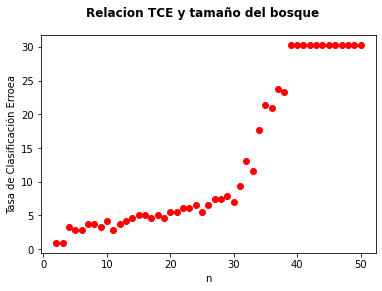

In [ ]:
#grafico
plt.scatter(x = np.arange(2,51),
            y = tce,
           color = 'red')
plt.suptitle("Relacion TCE y tamaño del bosque", fontweight = 'bold')
plt.xlabel("n")
plt.ylabel("Tasa de Clasificación Erroea")
plt.show

* Define la función `calcular_entropia`. Posteriormente entrena un bosque aleatorio de clasificación usando nuestra implementación pero usando árboles que usen la entropia como medida de impureza. Calcula la tasa de clasificación erronea usando el conjunto de datos de tiroides.


In [ ]:
def calcular_entropia(y):
  categorias = np.unique(y)
  val_entr = 0
  n_obs = len(y)

  for c in categorias:
    p_c = np.sum(y == c)/n_obs
    val_entr = p_c * np.log(p_c)

  return (-1)*val_entr

In [ ]:
# Definición del modelo
my_clas_rf_e = bosque_aleatorio_clas(B=100, m=2, m_imp="entropia")

In [ ]:
# Entrenamiento
my_clas_rf_e.entrenar(X.values,y.values)

In [ ]:
# Predicciones para todos los sujetos
preds_ba = my_clas_rf_e.predecir(X.values)
preds_ba

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 1, 1, 2, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1])

In [ ]:
# Matriz de confusión
mc_ba = pd.crosstab(preds_ba, np.ravel(y))
mc_ba

col_0,1,2,3
row_0,,,
1,149,10,6
2,0,25,0
3,1,0,24


In [ ]:
# Tasa de clasificación erronea
(1-np.diag(mc_ba).sum()/len(y))*100

7.906976744186045